In [14]:
import pandas as pd

# 파일 경로
file_path = '/content/sample_data/시계열분석_복합SCFI_2017.xlsx'

# 데이터를 불러옴
data = pd.read_excel(file_path)

# 데이터 확인
data.head()

from datetime import datetime

# 'YYYYMM' 컬럼을 datetime 객체로 변환
data['YYYYMM'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m')

# 시계열 데이터로 설정
data.set_index('YYYYMM', inplace=True)

# 데이터 확인
data.head()

# 테스트 데이터를 위해 마지막 6개월 분리
test_data = data.iloc[-6:]
train_data = data.iloc[:-6]

# 훈련 데이터와 테스트 데이터 확인
train_data.tail(), test_data.head()


(             SCFI_C
 YYYYMM             
 2016-11-01  820.398
 2016-12-01  838.530
 2017-01-01  971.137
 2017-02-01  869.975
 2017-03-01  775.174,
              SCFI_C
 YYYYMM             
 2017-04-01  834.060
 2017-05-01  860.922
 2017-06-01  869.764
 2017-07-01  878.540
 2017-08-01  864.205)

# 도표 17-34. 가법방식 Holt-Winters 모형 개발 파이썬 코드

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

# Holt-Winters 모델을 위한 최적의 평활 계수 찾기
def find_best_hw_params(train, test):
    best_rmse = float("inf")
    best_params = None

    # 가능한 alpha, beta, gamma 값의 조합 탐색
    for alpha in np.linspace(0.01, 1, 10):
        for beta in np.linspace(0.01, 1, 10):
            for gamma in np.linspace(0.01, 1, 10):
                try:
                    # Holt-Winters 모델 학습
                    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
                    predictions = model.forecast(len(test))

                    # RMSE 계산
                    rmse = np.sqrt(mean_squared_error(test, predictions))

                    # 최적의 평활 계수 저장
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = (alpha, beta, gamma)
                except:
                    continue

    return best_params, best_rmse

best_params, best_rmse = find_best_hw_params(train_data['SCFI_C'], test_data['SCFI_C'])
best_params, best_rmse


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-15-b564c5edd4bf>:16: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-15-b564c5edd4bf>:16: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
/usr/local/lib

((0.23, 1.0, 0.01), 52.849771012734486)

In [16]:
best_params, best_rmse

((0.23, 1.0, 0.01), 52.849771012734486)

# 도표 17-33. Holt-Winters 모형의 하이퍼파라미터 조정에 따른 RMSE

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-17-d7163482e2d6>:10: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=value, smoothing_slope=0.1, smoothing_seasonal=0.1)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-17-d7163482e2d6>:10: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=value, smoothing_slope=0.1, smoothing_seasonal=0.1)
/usr/local/lib/pytho

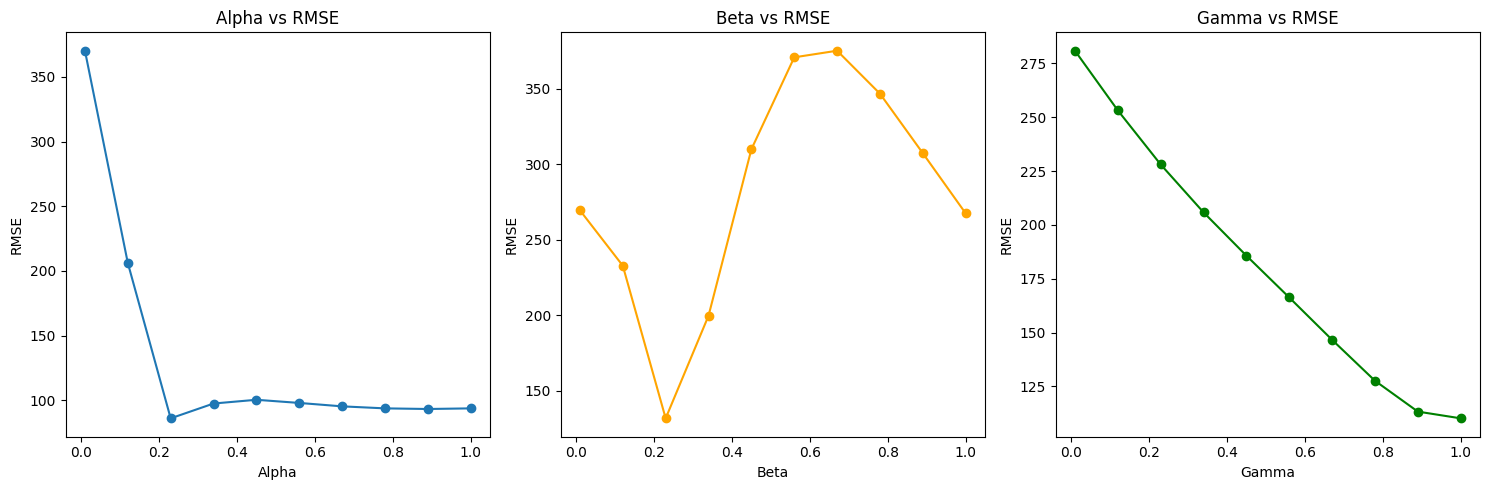

In [17]:
import matplotlib.pyplot as plt

# 각 평활계수에 대한 RMSE를 계산하는 함수
def compute_rmse_for_params(train, test, param_values, param_type):
    rmse_values = []

    for value in param_values:
        try:
            if param_type == 'alpha':
                model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=value, smoothing_slope=0.1, smoothing_seasonal=0.1)
            elif param_type == 'beta':
                model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=value, smoothing_seasonal=0.1)
            elif param_type == 'gamma':
                model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.1, smoothing_seasonal=value)
            predictions = model.forecast(len(test))
            rmse = np.sqrt(mean_squared_error(test, predictions))
            rmse_values.append(rmse)
        except:
            rmse_values.append(None)

    return rmse_values

# 각 평활계수에 대해 RMSE 계산
param_values = np.linspace(0.01, 1, 10)
alpha_rmse = compute_rmse_for_params(train_data['SCFI_C'], test_data['SCFI_C'], param_values, 'alpha')
beta_rmse = compute_rmse_for_params(train_data['SCFI_C'], test_data['SCFI_C'], param_values, 'beta')
gamma_rmse = compute_rmse_for_params(train_data['SCFI_C'], test_data['SCFI_C'], param_values, 'gamma')

# 그래프 그리기
plt.figure(figsize=(15, 5))

# Level 평활 계수 (Alpha)의 RMSE
plt.subplot(1, 3, 1)
plt.plot(param_values, alpha_rmse, marker='o')
plt.title('Alpha vs RMSE')
plt.xlabel('Alpha')
plt.ylabel('RMSE')

# Trend 평활 계수 (Beta)의 RMSE
plt.subplot(1, 3, 2)
plt.plot(param_values, beta_rmse, marker='o', color='orange')
plt.title('Beta vs RMSE')
plt.xlabel('Beta')
plt.ylabel('RMSE')

# Seasonal 평활 계수 (Gamma)의 RMSE
plt.subplot(1, 3, 3)
plt.plot(param_values, gamma_rmse, marker='o', color='green')
plt.title('Gamma vs RMSE')
plt.xlabel('Gamma')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()


# 도표 17-35. Holt-Winters 모형에서 계절성을 가법방식으로 설정한 예측 결과 그래프

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-18-f991cc3cd713>:2: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  optimal_model = ExponentialSmoothing(train_data['SCFI_C'], trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_params[0], smoothing_slope=best_params[1], smoothing_seasonal=best_params[2])


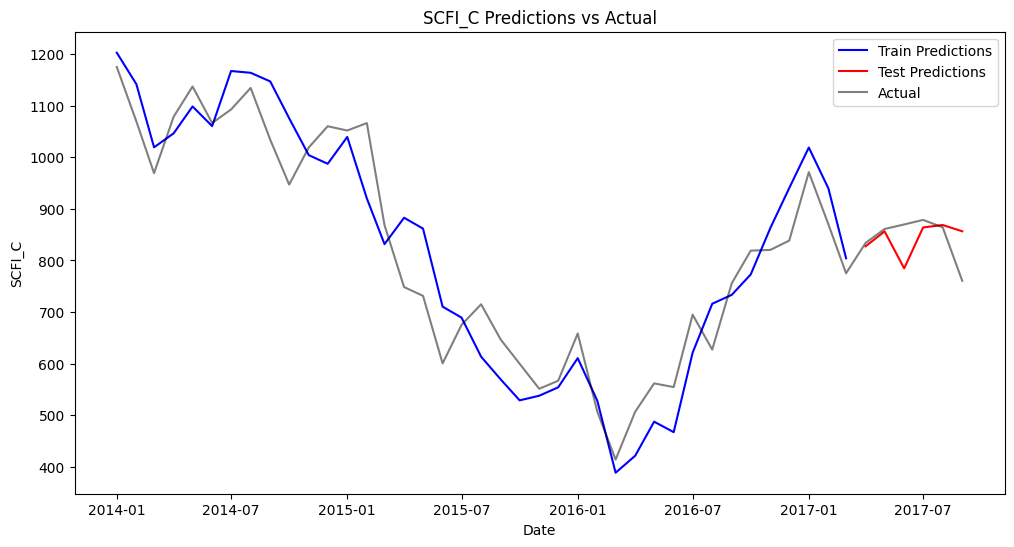

2017-04-01    827.417432
2017-05-01    856.330515
2017-06-01    784.649069
2017-07-01    863.955276
2017-08-01    868.674394
2017-09-01    856.540746
Freq: MS, dtype: float64

In [18]:
# 가장 낮은 RMSE를 갖는 모델로 예측
optimal_model = ExponentialSmoothing(train_data['SCFI_C'], trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_params[0], smoothing_slope=best_params[1], smoothing_seasonal=best_params[2])
train_predictions = optimal_model.fittedvalues
test_predictions = optimal_model.forecast(len(test_data))

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 훈련 데이터에 대한 예측값 (파란색)
plt.plot(train_data.index, train_predictions, label='Train Predictions', color='blue')

# 테스트 데이터에 대한 예측값 (빨간색)
plt.plot(test_data.index, test_predictions, label='Test Predictions', color='red')

# 전체 데이터에 대한 실적 (검은색)
plt.plot(data.index, data['SCFI_C'], label='Actual', color='black', alpha=0.5)

# 레전드 및 타이틀 설정
plt.title('SCFI_C Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('SCFI_C')
plt.legend()

plt.show()

test_predictions

In [19]:
test_data['Prediction'] = test_predictions
test_data

<ipython-input-19-db5ccb04e630>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Prediction'] = test_predictions


,SCFI_C,Prediction
YYYYMM,,
2017-04-01,834.060,827.417432
2017-05-01,860.922,856.330515
2017-06-01,869.764,784.649069
2017-07-01,878.540,863.955276
2017-08-01,864.205,868.674394
2017-09-01,760.540,856.540746


# 도표 17-37. Holt-Winters 모형에서 계절성을 승법방식 설정

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

# Holt-Winters 모델을 위한 최적의 평활 계수 찾기
def find_best_hw_params(train, test):
    best_rmse = float("inf")
    best_params = None

    # 가능한 alpha, beta, gamma 값의 조합 탐색
    for alpha in np.linspace(0.01, 1, 10):
        for beta in np.linspace(0.01, 1, 10):
            for gamma in np.linspace(0.01, 1, 10):
                try:
                    # Holt-Winters 모델 학습
                    model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
                    predictions = model.forecast(len(test))

                    # RMSE 계산
                    rmse = np.sqrt(mean_squared_error(test, predictions))

                    # 최적의 평활 계수 저장
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = (alpha, beta, gamma)
                except:
                    continue

    return best_params, best_rmse

best_params, best_rmse = find_best_hw_params(train_data['SCFI_C'], test_data['SCFI_C'])
best_params, best_rmse


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-20-b94fef203cd0>:16: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-20-b94fef203cd0>:16: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
/usr/local/lib

((0.23, 1.0, 0.12), 43.70639173607563)

In [21]:
best_params, best_rmse

((0.23, 1.0, 0.12), 43.70639173607563)

# 도표 17-36. Holt-Winters 모형에서 계절성을 승법방식으로 설정한 예측결과

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-22-aa42dc3ae6d2>:2: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  optimal_model = ExponentialSmoothing(train_data['SCFI_C'], trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_params[0], smoothing_slope=best_params[1], smoothing_seasonal=best_params[2])


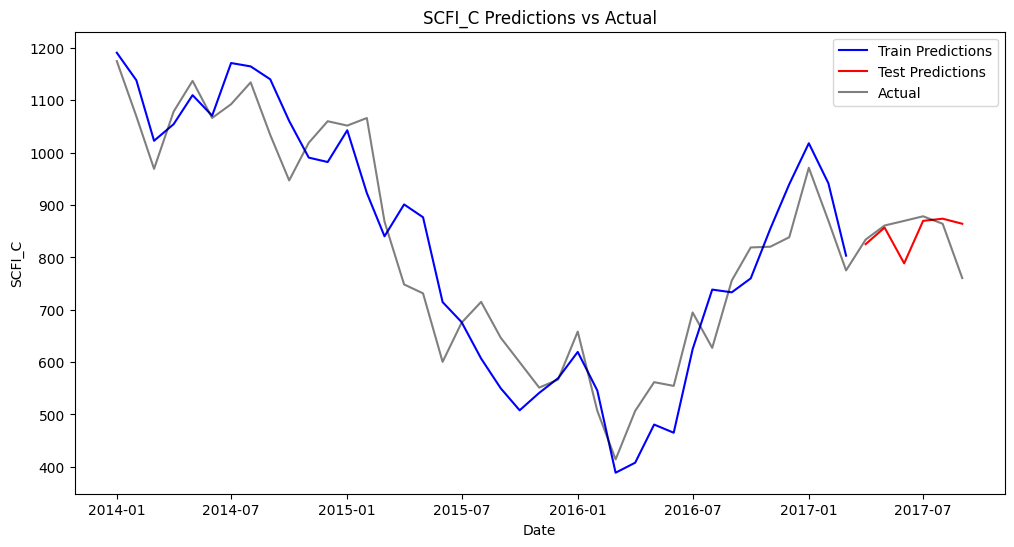

2017-04-01    825.341502
2017-05-01    856.897614
2017-06-01    788.653142
2017-07-01    869.794150
2017-08-01    873.944564
2017-09-01    864.295307
Freq: MS, dtype: float64

In [22]:
# 가장 낮은 RMSE를 갖는 모델로 예측
optimal_model = ExponentialSmoothing(train_data['SCFI_C'], trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_params[0], smoothing_slope=best_params[1], smoothing_seasonal=best_params[2])
train_predictions = optimal_model.fittedvalues
test_predictions = optimal_model.forecast(len(test_data))

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 훈련 데이터에 대한 예측값 (파란색)
plt.plot(train_data.index, train_predictions, label='Train Predictions', color='blue')

# 테스트 데이터에 대한 예측값 (빨간색)
plt.plot(test_data.index, test_predictions, label='Test Predictions', color='red')

# 전체 데이터에 대한 실적 (검은색)
plt.plot(data.index, data['SCFI_C'], label='Actual', color='black', alpha=0.5)

# 레전드 및 타이틀 설정
plt.title('SCFI_C Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('SCFI_C')
plt.legend()

plt.show()
test_predictions

In [23]:

test_data['Prediction'] = test_predictions
test_data

<ipython-input-23-db5ccb04e630>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Prediction'] = test_predictions


,SCFI_C,Prediction
YYYYMM,,
2017-04-01,834.060,825.341502
2017-05-01,860.922,856.897614
2017-06-01,869.764,788.653142
2017-07-01,878.540,869.794150
2017-08-01,864.205,873.944564
2017-09-01,760.540,864.295307


# 도표 17-38. Holt-Winters 승법 모형의 하이퍼파라미터 조정에 따른 RMSE

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-24-018f046efda3>:10: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=value, smoothing_slope=0.1, smoothing_seasonal=0.1)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-24-018f046efda3>:10: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=value, smoothing_slope=0.1, smoothing_seasonal=0.1)
/usr/local/lib/pytho

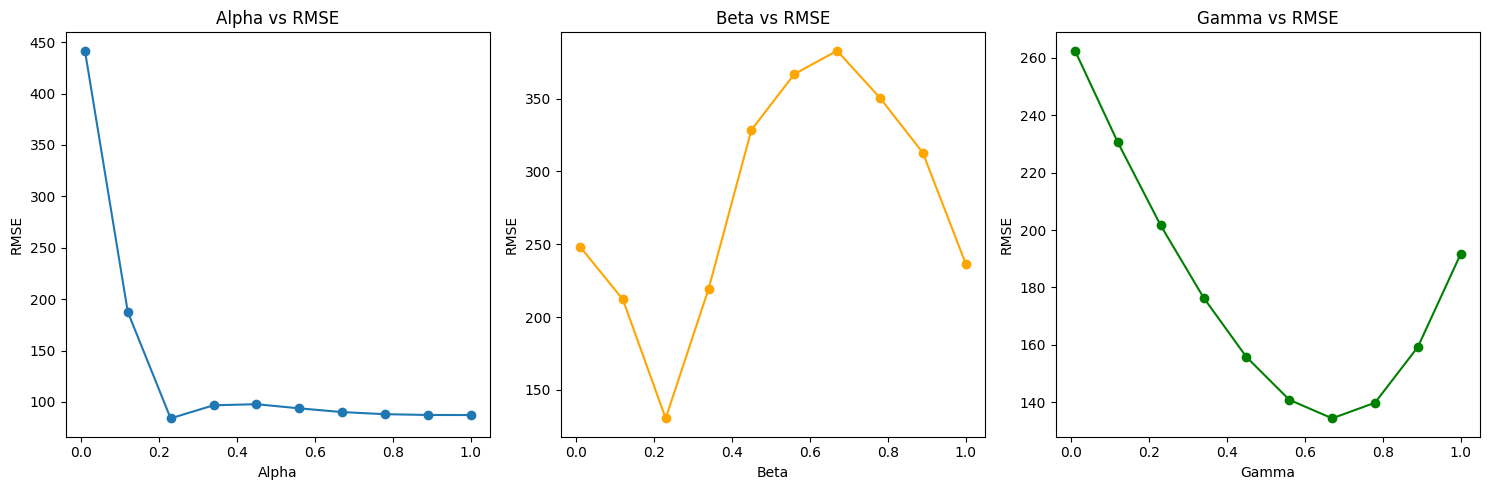

In [24]:
import matplotlib.pyplot as plt

# 각 평활계수에 대한 RMSE를 계산하는 함수
def compute_rmse_for_params(train, test, param_values, param_type):
    rmse_values = []

    for value in param_values:
        try:
            if param_type == 'alpha':
                model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=value, smoothing_slope=0.1, smoothing_seasonal=0.1)
            elif param_type == 'beta':
                model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=value, smoothing_seasonal=0.1)
            elif param_type == 'gamma':
                model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.1, smoothing_seasonal=value)
            predictions = model.forecast(len(test))
            rmse = np.sqrt(mean_squared_error(test, predictions))
            rmse_values.append(rmse)
        except:
            rmse_values.append(None)

    return rmse_values

# 각 평활계수에 대해 RMSE 계산
param_values = np.linspace(0.01, 1, 10)
alpha_rmse = compute_rmse_for_params(train_data['SCFI_C'], test_data['SCFI_C'], param_values, 'alpha')
beta_rmse = compute_rmse_for_params(train_data['SCFI_C'], test_data['SCFI_C'], param_values, 'beta')
gamma_rmse = compute_rmse_for_params(train_data['SCFI_C'], test_data['SCFI_C'], param_values, 'gamma')

# 그래프 그리기
plt.figure(figsize=(15, 5))

# Level 평활 계수 (Alpha)의 RMSE
plt.subplot(1, 3, 1)
plt.plot(param_values, alpha_rmse, marker='o')
plt.title('Alpha vs RMSE')
plt.xlabel('Alpha')
plt.ylabel('RMSE')

# Trend 평활 계수 (Beta)의 RMSE
plt.subplot(1, 3, 2)
plt.plot(param_values, beta_rmse, marker='o', color='orange')
plt.title('Beta vs RMSE')
plt.xlabel('Beta')
plt.ylabel('RMSE')

# Seasonal 평활 계수 (Gamma)의 RMSE
plt.subplot(1, 3, 3)
plt.plot(param_values, gamma_rmse, marker='o', color='green')
plt.title('Gamma vs RMSE')
plt.xlabel('Gamma')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()